# **Lab Exercise \#10: Size of the Galaxy, Part 2**


## **Load Python modules/packages (Run this every time)**

Run the following cell to load all the Python 3 modules and packages needed for this lab.

In [2]:
## Import system packages
import os
import glob

## Import astro packages
from astropy import *
import numpy as np
import astropy.io.fits as pyfits
from scipy import stats as sp_stats
from astropy.stats import sigma_clipped_stats
from scipy import signal
from scipy import ndimage

## gaussfitter package
import gaussfitter ## >>>>>>>> FOR THIS LAB, THIS IS A KEY PACKAGE

## plotting packages
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
plt.style.use(astropy_mpl_style)
from skimage import data, img_as_float
from skimage import exposure

## helper packages
import urllib, zipfile, tarfile
from urllib.request import urlretrieve
import warnings

## **Load all the data needed for the lab**

The following cell retrieves all the data needed for this lab from the web. Just run the cell without any changes.

We first check if a data directory exists in your Home/ directory, else we create it. Then the lab data are downloaded and saved in that directory. After you execute the following cell, go to the data directory and check to make sure you have all the needed files (your TA will guide you in doing this).

In [3]:

# retrieve the data as a tarball from the UVic website, and untar in home dir
Lab10_datadir = 'Globulars'

# Check if data dir exists, else retrieve data from UVic website
if not(os.path.exists(Lab10_datadir) and os.path.isdir(Lab10_datadir)):
    url = 'http://astrowww.phys.uvic.ca/~karun/UVicAstrLabs/A250/'
    tgz = Lab10_datadir+'.tgz'
    outfile = tgz
    urlretrieve(url+tgz, filename=outfile)
    tar = tarfile.open(outfile)
    tar.extractall()
    tar.close()

print('Size of Galaxy Lab data dir: ',Lab10_datadir)
print('List of available files:')
file_list = glob.glob(Lab10_datadir+'/*.fits')
for file in file_list:
    print(file)

Size of Galaxy Lab data dir:  Globulars
List of available files:
Globulars/ngc6626.fits
Globulars/m15.fits
Globulars/ngc6715.fits
Globulars/ngc6809.fits
Globulars/ngc6637.fits
Globulars/ngc6681.fits
Globulars/ngc6723.fits
Globulars/ngc6624.fits
Globulars/ngc6638.fits
Globulars/m3.fits
Globulars/ngc6656.fits
Globulars/ngc6652.fits


### **STEP 1: Get image information from the fits header**

Get basic header info from the image. For the first part of this lab exercise, we will use m3.fits. This is the globular cluster for which you measured the distance using the RR Lyrae stars in Part 1.


In [4]:
## READ THE IMAGE HEADER AND LIST THE DETAILS
## SPECIFY THE IMAGE BY THE INDEX IN THE LIST, file_list
infits = 'Globulars/m3.fits'
image_header = pyfits.getheader(infits, ext=0) ## this header info is needed for later
## LIST OUT THE REQUIRED HEADER DETAILS
header_details = ['OBJECT','TELESCOP','DATE-OBS','NAXIS1','NAXIS2']
for header_name in header_details:
    header_value = image_header[header_name]
    print(header_name,' = ',header_value)

OBJECT  =  dss15038
TELESCOP  =  Palomar 48-in Schm
DATE-OBS  =  1997/07/09
NAXIS1  =  594
NAXIS2  =  595


Number of rows, columns in image: 595 594


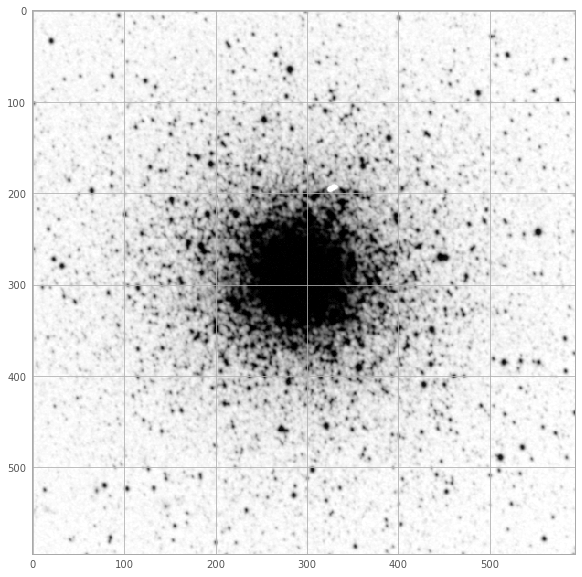

In [5]:
# READ THE IMAGE DATA, convert to float
image_data = pyfits.getdata(infits,ext=0)
image_data = image_data.astype(float)

# SCALE AND DISPLAY THE IMAGE, and choose an appropriate sub-region
plt.figure(figsize=(10,10))
# plt.figure()
# In this we are using Contrast stretching, 
# and inverted grey scale for better display
p2, p98 = np.percentile(image_data, (2, 98))
img_rescale = exposure.rescale_intensity(image_data, in_range=(p2, p98))
img_rescale = np.flipud(img_rescale)
plt.imshow(img_rescale, cmap='gray_r')
# plt.imshow(image_data, cmap='gray_r')

# Find the size of the image data array
[rows,cols] = image_data.shape
print('Number of rows, columns in image: %d %d' % (rows,cols))

### **Display the flux in 2D and 3D**

The image on the left shows the 2D projection of the flux distribution in the globular cluster. The 3D counterpart is shown in the right panel. The flux is in units of 10^4 ADU. The image has been smoothed in order to remove the effects of noise.

**NOTE: Due to processing time for these steps, the 2D and 3D flux distributions for M3 are shown as examples. You do not have to do these steps.** 

<table><tr>
<td> <img src="Globulars/M3_2Dflux.png" alt="Drawing" style="width: 500px; rotate: -90;"/> </td>
<td> <img src="Globulars/M3_3Dflux.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>


### **STEP 2: Estimate the Angular Size of the Globular Cluster**

We will fit a Gaussian to the 3D flux distribution of the globular cluster. Use the 1$\sigma$ width of the fitted Gaussian to estimate the full width at half maximum (FWHM). The FWHM of this fitted Gaussian will be taken to be the angular size of the globular cluster. 

**NOTE: For the sake of simplicity, we will take this Gaussian to be symmetric (circle=True) with the major axis aligned with the x-axis (rotate=False)**

In [6]:
moments = gaussfitter.moments(image_data, circle=True, rotate=False, vheight=False)
print('Fitted Gaussian parameters:')
print(moments)
print('The peak flux value [ADU]: %d' % (moments[0]))
print('The central position of globular cluster [pix]: %d , %d' % (moments[1],moments[2]))
print('The 1 sigma width [pix]: %.1f' % (moments[3]))

# Convert the Gaussian sigma to FWHM
sig2fwhm = 2.355 # conversion factor for sigma to FWHM
angsize2M3 = sig2fwhm*moments[3]
print('The angular size of the GC = FWHM[pix]: %.1f' % (angsize2M3))


Fitted Gaussian parameters:
[22363.0, 280, 324, 127.24687907629489]
The peak flux value [ADU]: 22363
The central position of globular cluster [pix]: 280 , 324
The 1 sigma width [pix]: 127.2
The angular size of the GC = FWHM[pix]: 299.7


### **STEP 3: IMPORTANT STEP: Building a function**

We are now ready to build a function for the above steps and run them for all the GCs.


In [7]:
def calculate_angularsize(infits):

# This function takes as input a fits image of the globular cluster
# fits a 2D Gaussian and then returns the fit parameters
# (x,y) centroids, sigma and the fwhm

    # READ THE IMAGE DATA, convert to float
    image_data = pyfits.getdata(infits,ext=0)
    image_data = image_data.astype(float)

    # Fit a 2D Gaussian (assumed to be symmetric)
    moments = gaussfitter.moments(image_data, circle=True, rotate=False, vheight=False)
    
    # Get the x,y centroids
    xcent = moments[1]
    ycent = moments[2]
    
    # Convert the Gaussian sigma to FWHM
    sig = moments[3]
    sig2fwhm = 2.355
    fwhm = sig2fwhm*sig
    return [xcent,ycent,sig,fwhm]


### **STEP 4: Calculate the angular sizes of all the GCs**

Run the function we built, calculate_angularsize for the images of all the GCs.


In [8]:
nfits = len(file_list)
file_vect = []
xcent_vect = []
ycent_vect = []
sig_vect = []
fwhm_vect = []
for i in range(nfits):
    infits = file_list[i]
    file_name = os.path.basename(infits)
    file_vect.append(file_name)
    [xcent,ycent,sig,fwhm] = calculate_angularsize(infits)
    xcent_vect.append(xcent)
    ycent_vect.append(ycent)
    sig_vect.append(sig)
    fwhm_vect.append(fwhm)


**Print out all the computed values**

You will use these values for all subsequent calculations.

In [9]:
# print out the computed values
print('%15s %8s %8s %8s %8s' % ('GC name  ', 'Xcent ', 'Ycent', 'Sigma', 'FWHM'))
for i in range(nfits):
    print('%15s %8.1f %8.1f %8.1f %8.1f' % (file_vect[i],xcent_vect[i],ycent_vect[i],sig_vect[i],fwhm_vect[i]))

      GC name     Xcent     Ycent    Sigma     FWHM
   ngc6626.fits    264.0    270.0    134.2    316.0
       m15.fits    251.0    278.0    120.5    283.8
   ngc6715.fits    264.0    264.0    137.9    324.7
   ngc6809.fits    260.0    245.0    125.8    296.3
   ngc6637.fits    264.0    267.0    137.6    324.0
   ngc6681.fits    265.0    270.0    141.7    333.6
   ngc6723.fits    264.0    255.0    117.7    277.1
   ngc6624.fits    273.0    268.0    142.0    334.3
   ngc6638.fits    269.0    264.0    142.9    336.4
        m3.fits    280.0    324.0    127.2    299.7
   ngc6656.fits    271.0    257.0    117.1    275.7
   ngc6652.fits    402.0    479.0    221.4    521.4


### **STEP 5: Distances to all the Globular Clusters**

Use the known distance and angular size of M3 to calculate the distances to all the other globular clusters, based on their angular sizes estimated above.

Use the distance to M3 which you calculated in Part I of this lab.

**Note: Insert a code cell below, calculate the distances and print them out neatly similar to the table above**

In [10]:
# FROM PART I: Mean distances to M3: 9.75e+03 [pc]
mean_dist2M3 = 9.75e+03
print('==================================================')
print('Mean distances to M3: %.2e [pc]' % (mean_dist2M3))
print('Angular size of M3: %.3f [pix]' % (angsize2M3))

# USE THE EQUATIONS GIVEN IN THE LAB MANUAL TO CALCULATE THE DISTANCES TO ALL THE GCs
# Insert the code here and print out the results neatly

# YOUR CODE GOES HERE
K = mean_dist2M3 * angsize2M3
numer = np.sum(fwhm_vect)
denom = np.sum(np.multiply(fwhm_vect,fwhm_vect))
mean_dist2CoG = K*numer/denom
print('Mean distance to the CoG: %.2e [pc]' % (mean_dist2CoG))

Mean distances to M3: 9.75e+03 [pc]
Angular size of M3: 299.666 [pix]
Mean distance to the CoG: 8.62e+03 [pc]
